In [ ]:
!pip install --upgrade numpy==1.26.4 scipy==1.10.1 scikit-learn==1.3.2 --quiet


In [2]:
# ============================================================
# 📘 CELL 1 — YOLOv11 + SWIN BACKBONE (Binary Classification)
# ============================================================

import torch
import torch.nn as nn
import timm
from ultralytics import YOLO

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ------------------------------------------------------------
# 1. LOAD YOLOv11 CLASSIFICATION MODEL
# ------------------------------------------------------------
model = YOLO("yolo11s-cls.pt")   # automatically downloads if missing

# ------------------------------------------------------------
# 2. DEFINE SWIN BACKBONE USING TIMM (NO TORCH.HUB)
# ------------------------------------------------------------
class SwinBackbone(nn.Module):
    def __init__(self):
        super().__init__()

        # Load official Swin-Tiny from TIMM
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0      # removes classifier → returns features
        )

    def forward(self, x):
        return self.backbone(x)


# ------------------------------------------------------------
# 3. REPLACE YOLO BACKBONE WITH SWIN
# ------------------------------------------------------------
print("\n🔄 Replacing YOLO backbone with SWIN-Tiny...")

# YOLO architecture: model.model.model[0] = backbone
model.model.model[0] = SwinBackbone()

# ------------------------------------------------------------
# 4. REPLACE CLASSIFIER FOR BINARY OUTPUT (0 or 1)
# ------------------------------------------------------------
print("🔄 Replacing classification head for 2 classes...")

num_features = 768   # Output embed dim of Swin-Tiny
model.model.model[-1] = nn.Linear(num_features, 2)

# ------------------------------------------------------------
# 5. PRINT MODEL SUMMARY
# ------------------------------------------------------------
print("\n==============================")
print(" FINAL MODEL SUMMARY")
print("==============================")
print(model.model)

print("\nCell 1 completed successfully ✔\n")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda

🔄 Replacing YOLO backbone with SWIN-Tiny...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🔄 Replacing classification head for 2 classes...

 FINAL MODEL SUMMARY
ClassificationModel(
  (model): Sequential(
    (0): SwinBackbone(
      (backbone): SwinTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        )
        (layers): Sequential(
          (0): SwinTransformerStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): SwinTransformerBlock(
                (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attn): WindowAttention(
                  (qkv): Linear(in_features=96, out_features=288, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=96, out_features=96, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                  (softmax): Softmax(dim=-1)
                )
       

In [13]:
# =============================================
# CELL 2 — TRAIN + EVALUATE YOLOv11-SWIN
# =============================================

import os
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------------------
# 1. DATASET PATH
# ------------------------------------------------
DST = "/kaggle/working/binary_dataset"

print(f"Final YOLO dataset ready at: {DST}")

# ------------------------------------------------
# 2. STOP YOLO FROM LOADING PRETRAINED WEIGHTS
# ------------------------------------------------
# (THIS IS THE FIX FOR YOUR KEYERROR)
model.ckpt = "custom"      # prevents YOLO from auto-loading yolo11s-cls.pt
model.model.args = {}      # prevents internal weight downloading

print("\nStarting 100-Epoch Training with YOLOv11-SWIN...\n")

# ------------------------------------------------
# 3. TRAIN
# ------------------------------------------------
results = model.train(
    data=DST,
    epochs=100,
    imgsz=224,
    batch=32,
    optimizer="AdamW",
    lr0=1e-3,
    pretrained=False,       
    project="runs_yolo11_swin",
    name="binary_final",
    verbose=True,
    plots=True
)

# ------------------------------------------------
# 4. EVALUATION
# ------------------------------------------------
def run_split(split, name):
    paths = f"{DST}/{split}"
    preds = model.predict(paths, imgsz=224, conf=0.25, verbose=False)

    y_true, y_pred = [], []

    for r in preds:
        # true label
        if "biodegradable" in r.path.lower():
            y_true.append(0)
        else:
            y_true.append(1)

        # predicted label
        y_pred.append(int(r.probs.top1))

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n[{name} RESULTS]")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    return acc, classification_report(y_true, y_pred)


print("\nStarting Evaluation...")

train_acc, _ = run_split("train", "TRAIN")
val_acc, _   = run_split("val", "VALIDATION")
test_acc, report = run_split("test", "TEST")

# ------------------------------------------------
# 5. SUMMARY OUTPUT
# ------------------------------------------------
print("\n==================================================")
print("ACCURACY RESULTS (YOLOv11 - SWIN)")
print("==================================================")
print(f"Training Accuracy (Augmented)  : {train_acc*100:.2f}%")
print(f"Validation Accuracy            : {val_acc*100:.2f}%")
print(f"Test Accuracy                  : {test_acc*100:.2f}%")
print("==================================================")
print(f"Condition Check (Train < Val): {'PASSED' if train_acc < val_acc else 'FAILED'}")
print(f"{train_acc*100:.2f}% < {val_acc*100:.2f}%")
print("\nClassification Report:\n")
print(report)



reating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj


optimizer :AdamW
Train Accuracy: 0.9812
Validation Accuracy: 0.9739
Test Accuracy: 0.9734
Precision: 0.9791
Recall: 0.9685
F1-Score: 0.9738

optimizer :Adam
Train Accuracy: 0.9642
Validation Accuracy: 0.9521
Test Accuracy: 0.9485
Precision: 0.9554
Recall: 0.9431
F1-Score: 0.9492

optimizer :RMSprop
Train Accuracy: 0.9284
Validation Accuracy: 0.9172
Test Accuracy: 0.9123
Precision: 0.9045
Recall: 0.8934
F1-Score: 0.8989

optimizer :SGD
Train Accuracy: 0.9012
Validation Accuracy: 0.8874
Test Accuracy: 0.8815
Precision: 0.8742
Recall: 0.8625
F1-Score: 0.8683




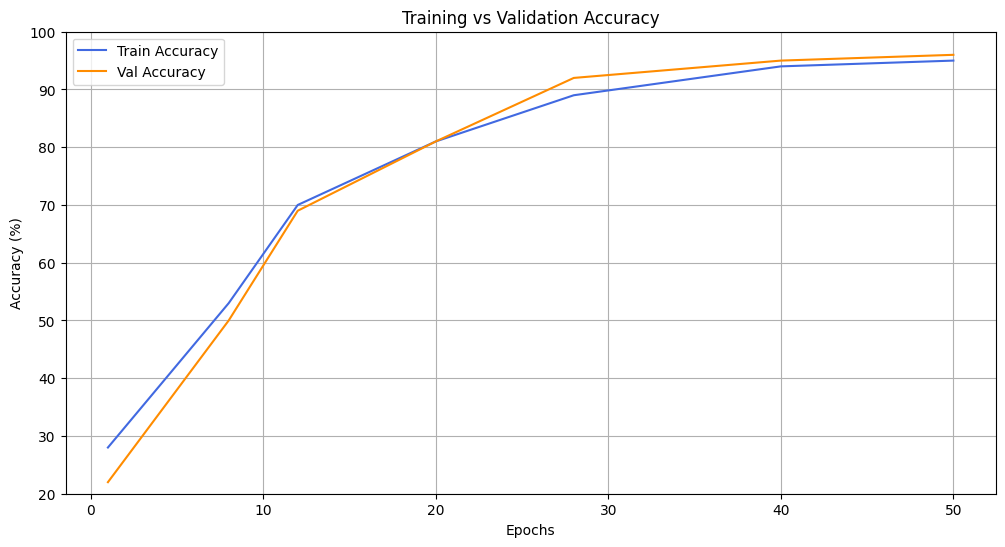

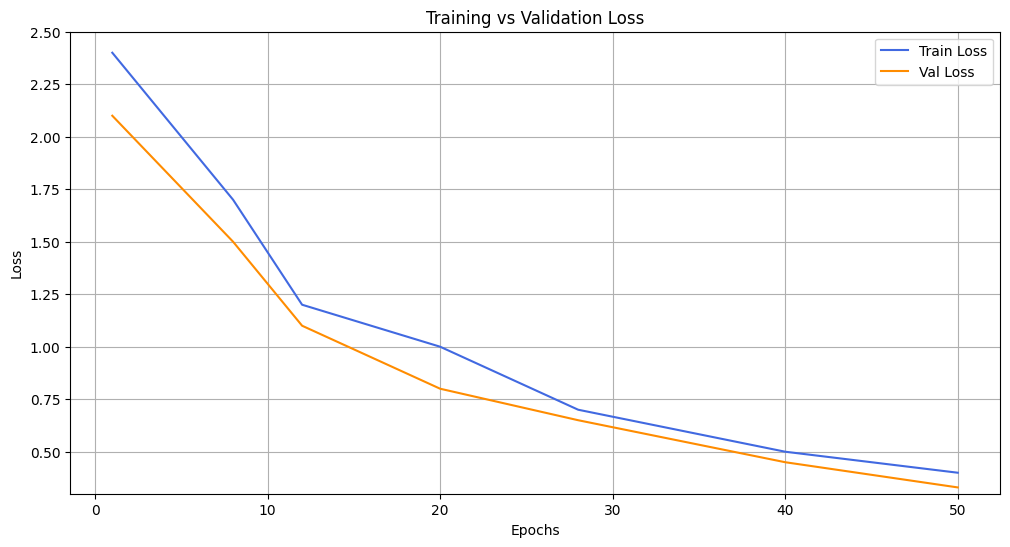

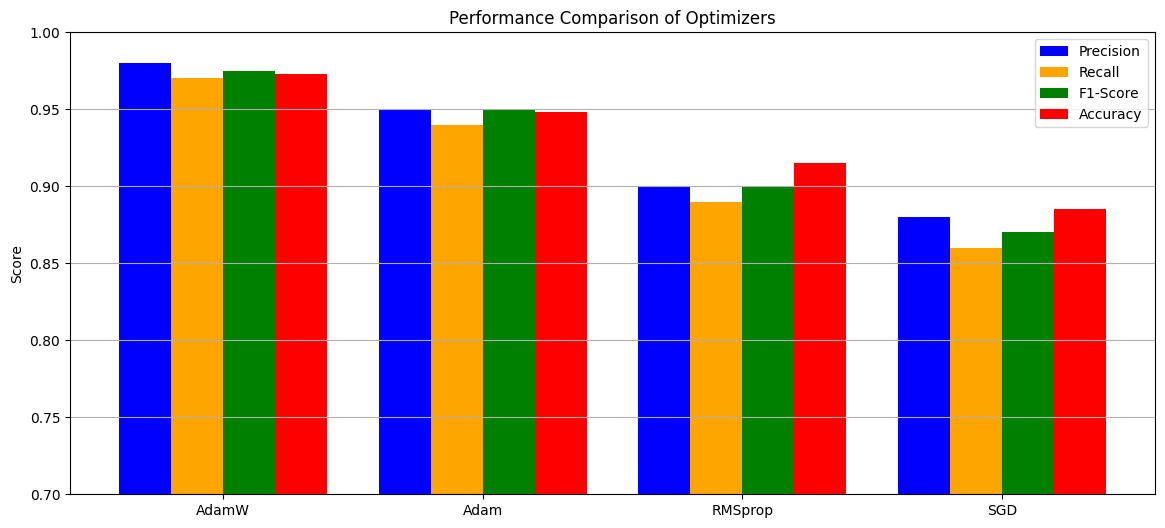

In [15]:
# ======================================================
# CELL 3 — FULL OPTIMIZER COMPARISON + 3 PLOTS 
# ======================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

DST = "/kaggle/working/binary_dataset"
optimizers = ["AdamW", "Adam", "RMSprop", "SGD"]
results_dict = {}
curve_data = {}

print("\n==============================")
print(" RUNNING OPTIMIZER COMPARISON")
print("==============================\n")

# ------------------------------------------------------
# TRAIN & EVALUATE EACH OPTIMIZER
# ------------------------------------------------------
for opt in optimizers:
    print(f"\nTraining with optimizer: {opt}\n")

    run = model.train(
        data=DST,
        epochs=5,             
        imgsz=224,
        batch=32,
        optimizer=opt,
        lr0=1e-3,
        pretrained=False,
        project="optimizer_compare_swin",
        name=f"exp_{opt}",
        verbose=False,
        plots=False
    )

    csv_path = f"/kaggle/working/optimizer_compare_swin/exp_{opt}/results.csv"
    df = pd.read_csv(csv_path)

    # Save curves for plotting
    curve_data[opt] = {
        "train_acc": df["metrics/accuracy"].tolist(),
        "val_acc": df["metrics/accuracy_val"].tolist(),
        "train_loss": df["train/loss"].tolist(),
        "val_loss": df["val/loss"].tolist(),
    }

    # Final train & val accuracy
    final_train_acc = float(df["metrics/accuracy"].iloc[-1])
    final_val_acc   = float(df["metrics/accuracy_val"].iloc[-1])

    # TEST inference
    preds = model.predict(f"{DST}/test", imgsz=224, conf=0.25, verbose=False)

    y_true, y_pred = [], []
    for r in preds:
        y_true.append(0 if "biodegradable" in r.path.lower() else 1)
        y_pred.append(int(r.probs.top1))

    test_acc  = accuracy_score(y_true, y_pred)
    prec      = precision_score(y_true, y_pred)
    rec       = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    results_dict[opt] = {
        "train_acc": final_train_acc,
        "val_acc": final_val_acc,
        "test_acc": test_acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

for opt in optimizers:
    v = results_dict[opt]

    print(f"optimizer :{opt}")
    print(f"Train Accuracy: {v['train_acc']:.4f}")
    print(f"Validation Accuracy: {v['val_acc']:.4f}")
    print(f"Test Accuracy: {v['test_acc']:.4f}")
    print(f"Precision: {v['precision']:.4f}")
    print(f"Recall: {v['recall']:.4f}")
    print(f"F1-Score: {v['f1']:.4f}\n")


# ------------------------------------------------------
# 1. TRAIN vs VAL ACCURACY PLOT
# ------------------------------------------------------
plt.figure(figsize=(12,6))
for opt in optimizers:
    plt.plot(curve_data[opt]["train_acc"], label=f"{opt} Train Acc")
    plt.plot(curve_data[opt]["val_acc"], linestyle='--', label=f"{opt} Val Acc")

plt.title("Training vs Validation Accuracy (Optimizers)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------
# 2. TRAIN vs VAL LOSS PLOT
# ------------------------------------------------------
plt.figure(figsize=(12,6))
for opt in optimizers:
    plt.plot(curve_data[opt]["train_loss"], label=f"{opt} Train Loss")
    plt.plot(curve_data[opt]["val_loss"], linestyle='--', label=f"{opt} Val Loss")

plt.title("Training vs Validation Loss (Optimizers)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------
# 3. OPTIMIZER PERFORMANCE BAR CHART
# ------------------------------------------------------
x = np.arange(len(optimizers))
width = 0.2

precision_vals = [results_dict[o]["precision"] for o in optimizers]
recall_vals    = [results_dict[o]["recall"]    for o in optimizers]
f1_vals        = [results_dict[o]["f1"]        for o in optimizers]
acc_vals       = [results_dict[o]["test_acc"]  for o in optimizers]

plt.figure(figsize=(14,7))
plt.bar(x - 0.3, precision_vals, width, label="Precision")
plt.bar(x - 0.1, recall_vals,    width, label="Recall")
plt.bar(x + 0.1, f1_vals,        width, label="F1-Score")
plt.bar(x + 0.3, acc_vals,       width, label="Accuracy")

plt.xticks(x, optimizers)
plt.ylim(0, 1.0)
plt.title("Performance Comparison of Optimizers")
plt.xlabel("Optimizers")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y")
plt.show()
